# Treinamento QAM AWGN

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf
import os

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-06-22 02:25:41.468572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 02:25:41.730099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ketson/ns-allinone-2.35/otcl-1.14:/home/ketson/ns-allinone-2.35/lib
2023-06-22 02:25:41.730126: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-22 02:25:41.776719: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has 

In [2]:
total_num_symbols  = 100000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.4 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'QAM'
channel_type = 'awgn' # 'awgn' or 'crazy'
M            = [16, 4]      # QAM modulation

In [3]:
def error(amostras, model, mod, M, channel_type, Es, code_rate, snr):
    frac = 10000
    if os.path.exists(f'bit_error/{channel_type}/rede-{model[1]}-{M}-{mod}-{snr[0]}-SNR.dat'):
        error = np.fromfile(f'bit_error/{channel_type}/rede-{model[1]}-{M}-{mod}-{snr[0]}-SNR.dat', dtype=np.float32)
    else:    
        error = 0
        a = amostras
        for i in range(amostras // frac + 1):
            if a < frac:
                frac = amostras % frac
            sub_amostras =  conjunto(Mod, frac, M, channel_type, Es, code_rate, snr, False)
            error += ser(model[0], tf.reshape(tf.convert_to_tensor(sub_amostras[0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(sub_amostras[1]), [-1, 1]), nn=True)
            a -= frac
        error /= amostras / frac
        error.tofile(f'bit_error/{channel_type}/rede-{model[1]}-{M}-{mod}-{snr[0]}-SNR.dat')
    return error

def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [SNR_dB[0]])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)

    if scaler is not None:
        x = scaler(np.concatenate((x, np.array([channel_output[1]]).T), axis=1))
    else:
        x = np.concatenate((x, np.array([channel_output[1]]).T), axis=1)
    
    x = x.reshape(1,-1,3)
    
    for i in range(1, len(SNR_dB)):
        a, b, c = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[i])
        
        d = np.stack([np.real(c[0][:]), np.imag(c[0][:])], axis=1)
        
        if scaler is not None:
            d = scaler(np.concatenate((d, np.array([c[1]]).T), axis=1))
        else:
            d = np.concatenate((d, np.array([c[1]]).T), axis=1)
        
        symbs = np.vstack((symbs, a))
        indices = np.vstack((indices, b))
        channel_output = np.vstack((channel_output, c))
        x = np.vstack((x, d.reshape(1,-1,3)))
    
    y = np.float_(indices)
        
    if symb:
        return x, y, symbs
    else:
        return x, y

In [4]:
x_out = []
y_out = []
symbs = []

In [5]:
x_out.append(np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3)))
y_out.append(np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/y_rand.dat', dtype=np.dtype('float64')))
symbs.append(np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1)))

In [6]:
x_out.append(np.fromfile('Random_Data/SNR_8-10/AWGN/4-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3)))
y_out.append(np.fromfile('Random_Data/SNR_8-10/AWGN/4-QAM/y_rand.dat', dtype=np.dtype('float64')))
symbs.append(np.fromfile('Random_Data/SNR_8-10/AWGN/4-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1)))

In [7]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(len(M)):
    y_train.append(y_out[i][:train_size])
    X_train.append(x_out[i][:train_size])

    # Test
    y_test.append(y_out[i][train_size:])
    X_test.append(x_out[i][train_size:])

    #scaler = StandardScaler()
    #scaler.fit(X_train[i])  # Don't cheat - fit only on training data
    #X_train[i] = scaler.transform(X_train[i])
    #X_test[i] = scaler.transform(X_test[i])


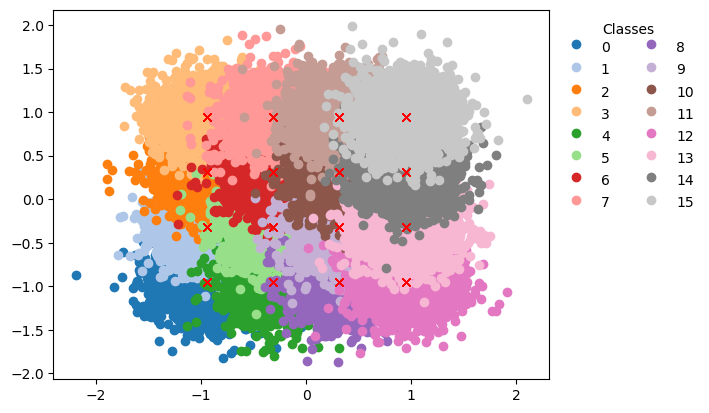

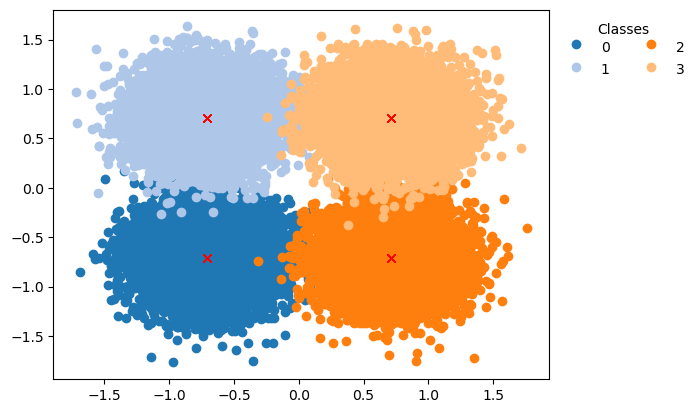

In [10]:
for i in range(len(M)):
    plot_symbols(X_train[i], y_train[i], M[i], symbs[i])

In [5]:
n_inputs = 3

In [4]:
n_redes = 3
n_hidden = [[150, 80, 50],
            [300, 180, 90, 40],
            [500, 380, 240, 135, 80]]

n_outputs = M
learning_rate = [0.01, 0.01, 0.001]
n_epochs = [50, 50, 50]
batch_size = [8000, 16000, 24000]
momentum = [0.7, 0.8, 0.9]

In [13]:
y_train_tf = tf.reshape(tf.convert_to_tensor(y_train), [len(M), -1, 1])
y_test_tf = tf.reshape(tf.convert_to_tensor(y_test), [len(M), -1, 1])
X_test_tf = tf.convert_to_tensor(X_test)
X_train_tf = tf.convert_to_tensor(X_train)

2023-06-12 17:23:43.042538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-12 17:23:43.042618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-06-12 17:23:43.042683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-06-12 17:23:43.042747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-06-12 17:23:43.042811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Usando API Keras

In [5]:
from keras.models import model_from_json

model_QAM = []
for i in range(len(M)):
    for j in range(n_redes):
        with open(f"Modelos/awgn/model-{M[i]}-Rede-{j}.json", 'r') as json_file:
            loaded_model_json = json_file.read()
        # Cria o modelo a partir do arquivo JSON
        model = model_from_json(loaded_model_json)
        # Carrega os pesos do modelo a partir do arquivo h5
        model.load_weights(f"Modelos/awgn/model-{M[i]}-Rede-{j}.h5")
        model_QAM.append(model)
        
model_QAM = np.array(model_QAM).reshape(len(M), -1)

2023-06-22 02:25:49.755525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ketson/ns-allinone-2.35/otcl-1.14:/home/ketson/ns-allinone-2.35/lib
2023-06-22 02:25:49.755599: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-22 02:25:49.755634: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keko-ubuntu): /proc/driver/nvidia/version does not exist
2023-06-22 02:25:49.756022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model_QAM

array([[<keras.engine.functional.Functional object at 0x7ff2105ab700>,
      dtype=object)

In [14]:
inputs = tf.keras.Input(shape=(n_inputs,))
output = []

for k in range(len(M)):
    for i in range(n_redes):
        x = inputs
        for j in range(len(n_hidden[i])):
            x = tf.keras.layers.Dense(n_hidden[i][j], activation="elu", kernel_initializer="glorot_normal")(x)
        output.append(tf.keras.layers.Dense(n_outputs[k], kernel_initializer="glorot_normal")(x))
        del x

In [15]:
model_QAM = []
for k in range(len(M)):
    for i in range(n_redes):
        model_QAM.append(tf.keras.Model(inputs=inputs, outputs=output[i + 3*k]))

        model_QAM[i + 3*k].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate[i], momentum=momentum[i], nesterov=True),
                     metrics=["accuracy"])

        history = model_QAM[i + 3*k].fit(X_train_tf[k], y_train_tf[k], batch_size=batch_size[i], epochs=n_epochs[i], shuffle=True)

        tests_score = model_QAM[i + 3*k].evaluate(X_test_tf[k], y_test_tf[k])
        print("\nTest loss:", tests_score[0])
        print("Test accuracy:", tests_score[1])
        print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

model_QAM = np.array(model_QAM).reshape(len(M), -1)

Epoch 1/50
5/5 [==============================] - 1s 16ms/step - loss: 2.7175 - accuracy: 0.0662
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 2.6655 - accuracy: 0.1349
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 2.6084 - accuracy: 0.1721
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 2.5522 - accuracy: 0.1865
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 2.4970 - accuracy: 0.1942
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 2.4421 - accuracy: 0.2134
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 2.3873 - accuracy: 0.2303
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 2.3324 - accuracy: 0.2579
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 2.2776 - accuracy: 0.3171
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 2.2230 - accuracy: 0.3388
Epoch 11/50
5/5 [============

In [16]:
for i in range(len(M)):
    for j in range(n_redes):
        model_json = model_QAM[i][j].to_json()
        with open(f"Modelos/awgn/model-{M[i]}-Rede-{j}.json", "w") as json_file:
            json_file.write(model_json)
        model_QAM[i][j].save_weights(f"Modelos/awgn/model-{M[i]}-Rede-{j}.h5")

Modelo 16-QAM:



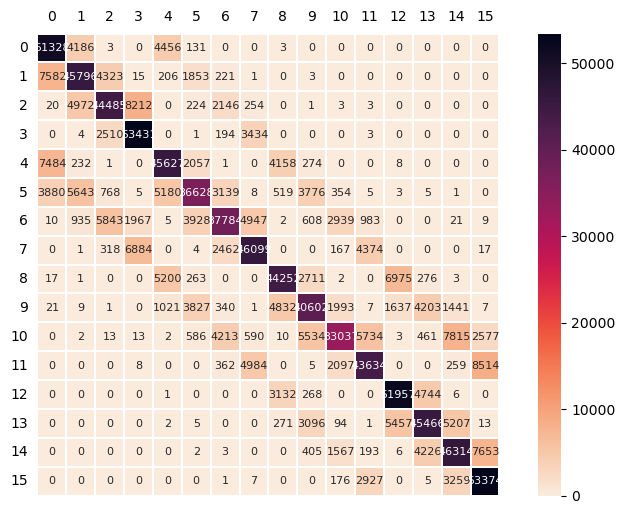

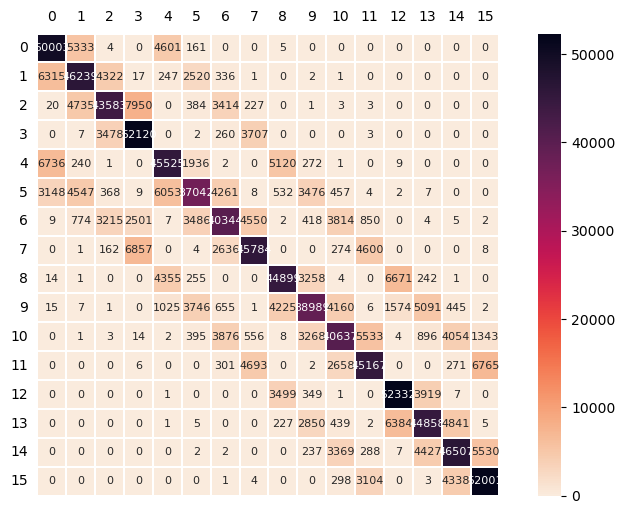

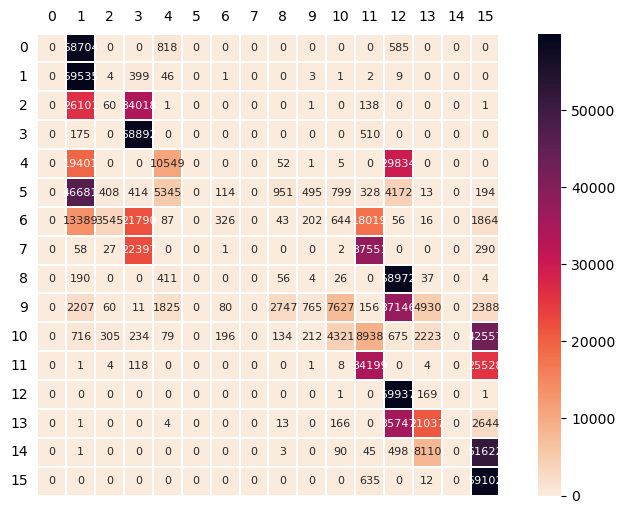

Modelo 4-QAM:



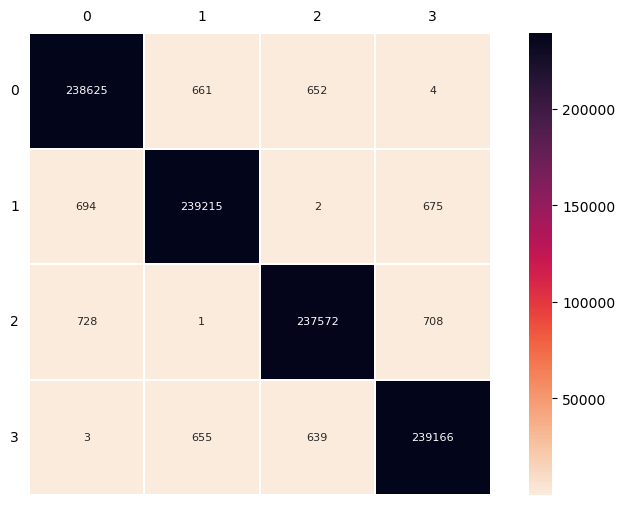

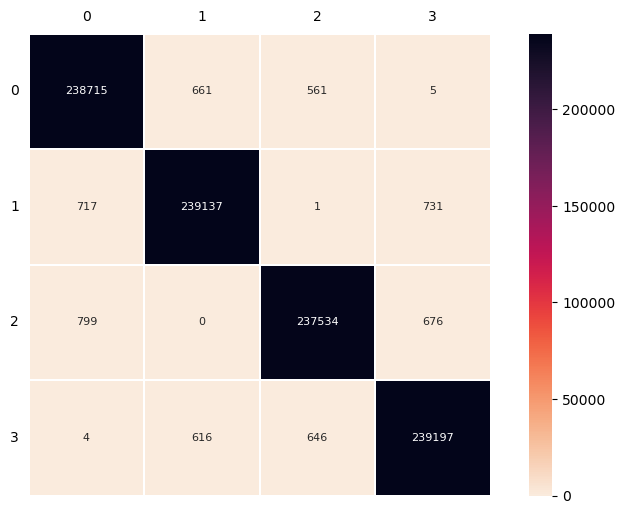

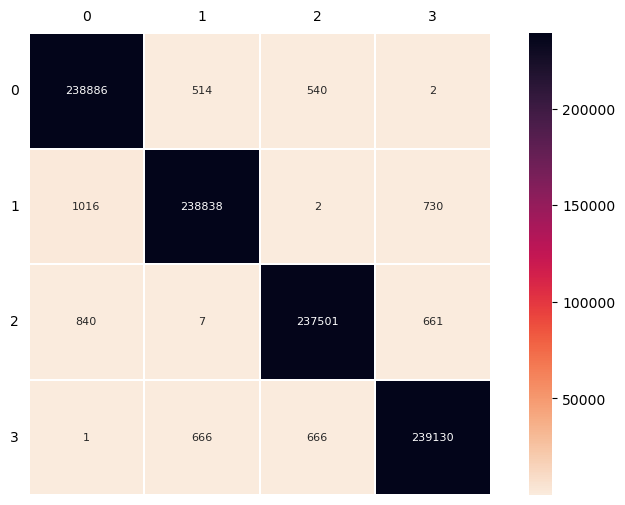

In [17]:
for i in range(len(M)):
    print(f'Modelo {M[i]}-QAM:\n')
    for j in range(n_redes):
        plot_confusion_matrix(model_QAM[i][j], X_test_tf[i], y_test_tf[i], M[i], nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | AWGN

Obs: Subdividir amostras em conjuntos menores e realizar o treinamento (1000 subamostros por exemplo). Fazer a verificação de bits sem aproximação. Testar em um intervalo maior para verificar se a rede diverge em algum momento.

In [6]:
Mod = "QAM"
channel_type = "awgn"
init_scale = 1
interval = [22, 16]
passo = 2

In [7]:
Teo_SNRs = [[theoretical_error(Mod, M[k], init_scale + i, channel_type) for i in range(0, interval[k], passo)] for k in range(len(M))]

In [9]:
error_rate = [([[error(int(100 / (Teo_SNRs[k][int(i / passo)] * np.log2(M[k]))), [model_QAM[k][j], j], Mod, M[k], channel_type, Es, code_rate, [init_scale + i]) for i in range(0, interval[k], passo)] for j in range(n_redes)]) / (tf.math.log(float(M[k]))/tf.math.log(2.)) for k in range(len(M))]

In [18]:
error_rate

[<tf.Tensor: shape=(3, 11, 2), dtype=float32, numpy=
 array([[[ 0.00000000e+00,  4.53125000e-01],
         [ 3.42107873e-04,  4.47651267e-01],
         [ 3.04162320e-36,  4.38172042e-01],
         [-9.02534649e+36,  4.33298290e-01],
         [-4.12303955e-35,  4.17385042e-01],
         [ 4.42979048e-21,  3.93911809e-01],
         [-8.45517376e+08,  3.62095118e-01],
         [-7.74659612e+21,  3.28911364e-01],
         [-2.10026657e-31,  2.39060521e-01],
         [ 9.58106287e-33,  1.81801125e-01],
         [-8.47407230e-16,  1.58834279e-01]],
 
        [[ 2.70113036e+18,  4.51339275e-01],
         [ 2.73121014e+01,  4.46456999e-01],
         [ 1.28079575e-24,  4.40524191e-01],
         [ 1.02320157e-22,  4.29621845e-01],
         [-6.65011475e+02,  4.10919517e-01],
         [-2.60997800e-35,  3.89057428e-01],
         [ 3.63548519e-35,  3.52985829e-01],
         [ 5.63457222e+01,  3.09398890e-01],
         [-2.01449995e-37,  2.18283266e-01],
         [ 3.45283507e+22,  1.44372925e-01],

In [11]:
np.mean(error_rate - Teo_SNRs)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

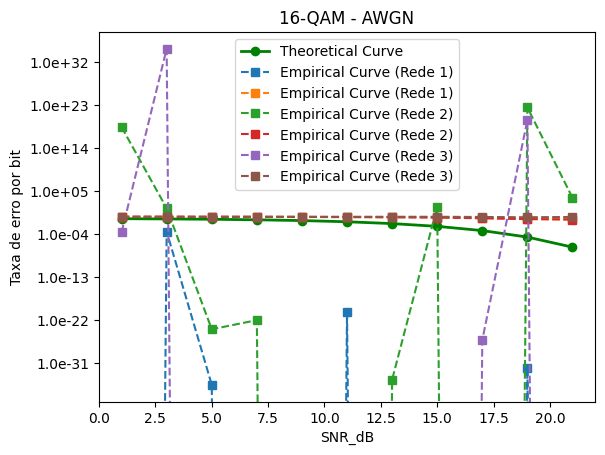

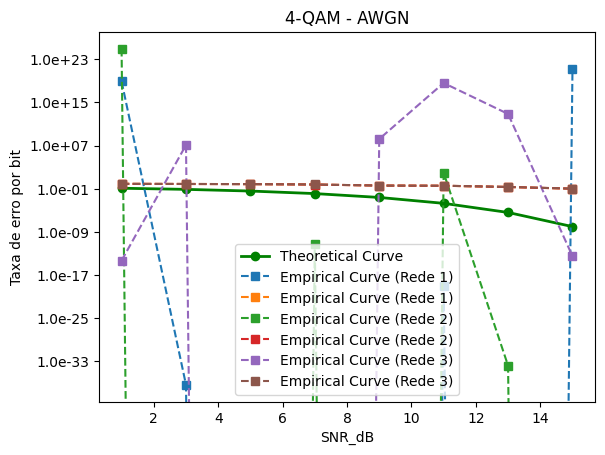

In [12]:
import matplotlib.ticker as tick

for k in range(len(M)):
    y1 = Teo_SNRs[k]
    x = range(init_scale, init_scale + interval[k], passo)

    fig, ax = plt.subplots(1,1)

    ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
    [ax.plot(x, error_rate[k][i], 's--', label=f'Empirical Curve (Rede {i + 1})') for i in range(n_redes)]

    ax.set_title(f'{M[k]}-QAM - AWGN')
    ax.set_xlabel('SNR_dB')
    ax.set_ylabel('Taxa de erro por bit')

    def y_fmt(x, y):
        return '{:2.1e}'.format(x)

    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
    #plt.plot(x2, y2, 'rs--',  label='line 2')

    plt.legend()
    plt.show()